# 🎮 Genshin Impact Wishing Simulator  
### Approximating the Probability Distribution of Gacha Outcomes via Bayesian Inference and Hamiltonian Monte Carlo

👤 Jerry¹ | 👤 Viriya Gunawan Lim²  
¹Actuarial Science, Universitas Indonesia  
²Actuarial Science, Universitas Indonesia  
📧 jerry11@ui.ac.id | 📧 viriya.gunawan@ui.ac.id  

---

## 📌 Abstract

This project analyzes the **probability distribution of character/item draws in gacha systems**, focusing on *Genshin Impact*.  
We aim to estimate the likelihood of achieving **maximum constellation (C6)** for featured characters within a finite number of pulls.  

We simulate banner outcomes using **Monte Carlo methods** under the rules of pity and guarantee, and then approximate the **probability density function (PDF)** of required pulls using **Bayesian inference with Hamiltonian Monte Carlo (HMC)**.  
This allows us to estimate:
- 🎯 Probability of pulling a rate-up ⭐⭐⭐⭐⭐ (5★) character.  
- 🎯 Distribution of ⭐⭐⭐⭐ (4★) rate-ups vs non–rate-ups.  
- 🎯 Likelihood of reaching **C6** within a budget of pulls.  

---

## 🧩 Introduction

Gacha systems like those in Genshin Impact rely on **hidden probability distributions**, modified by mechanics such as:
- **Pity** (increasing probabilities after a threshold of failed pulls).  
- **Guarantees** (e.g., 50/50 rule on 5★, next one guaranteed).  

Players and developers alike are interested in:
- The **probability of obtaining rare characters/items**.  
- The **distribution of pulls required** to reach targets like *C6*.  

Traditional simulation (Monte Carlo) gives an *empirical* distribution, but does not easily provide uncertainty estimates.  
Bayesian statistical models, combined with **Markov Chain Monte Carlo (MCMC)** — in particular, the **Hamiltonian Monte Carlo** method — allow us to approximate the full **posterior distribution** of the gacha outcome parameters.  

---

## 🧮 Methods

### 1. **Simulation**
We encode banner rules:
- Base rates:  
  - ⭐⭐⭐⭐⭐ (5★) ≈ 0.6%  
  - ⭐⭐⭐⭐ (4★) ≈ 5.1%  
- Soft pity thresholds:  
  - 5★ after 73 pulls  
  - 4★ after 8 pulls  
- Guarantees:  
  - 50/50 win/loss rule for 5★  
  - Guaranteed featured 4★ after one non–rate-up  

Simulation via **Monte Carlo** generates outcome frequencies across many banners.

---

### 2. **Bayesian Framework**
We model the probability \( p \) of pulling a desired item as unknown.  
Using Bayes’ Theorem:

\[
p(\theta \mid \text{data}) \propto p(\text{data} \mid \theta)\, p(\theta)
\]

- **Prior**: Beta distribution \( \mathrm{Beta}(\alpha_0, \beta_0) \)  
- **Likelihood**: Binomial model of pulls vs successes  
- **Posterior**: Updated distribution for \( p \) after observed pulls  

---

### 3. **Hamiltonian Monte Carlo (HMC)**
- Used to sample efficiently from the **posterior distribution**.  
- Captures correlations in parameters and converges faster than basic Metropolis–Hastings.  
- Implemented using probabilistic programming frameworks (e.g., PyMC, Stan).  

This gives:
- Posterior mean of \( p \) (probability of success).  
- **95% credible intervals**.  
- Derived quantities such as *expected pulls to first 5★* or *probability of hitting C6 within N pulls*.  

---

## 📊 Results & Interpretation

- Simulation outputs show **empirical distributions** of 4★/5★ pulls.  
- Bayesian HMC approximates the **true PDF** of the required pulls.  
- From this, we estimate:  
  - 📌 **Expected pulls** for 1 copy of a rate-up 5★.  
  - 📌 **Probability of reaching C6 within budget** (e.g., 90, 180, or 1080 pulls).  
  - 📌 **Uncertainty ranges** via credible intervals.  

---

## ✅ Conclusion

- Gacha systems can be understood as **probabilistic models** with pity and guarantees.  
- Monte Carlo simulation gives baseline frequencies.  
- Bayesian inference with **Hamiltonian Monte Carlo** refines this into full distributions with uncertainty quantification.  
- This approach improves **fairness analysis** and helps players understand their odds for C6 or featured pulls.  

---

## 🔮 Future Work
- Extend to **weapon banners** (different pity).  
- Compare across multiple banners/events.  
- Incorporate **empirical data from players** to refine priors.  
- Visualize **density curves** of pulls-to-target with posterior bands.

---



# Preparation


In [ ]:
import random
import collections, numpy
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def drop4(list1,guarantee4):
  list4 = ["Rate-up 4* 1","Rate-up 4* 2","Rate-up 4* 3","Non rate-up 4*"]
  y = random.uniform(0,1)
  if guarantee4==0:
    if y<1/6:
        list1.append("Rate-up 4* 1")
    elif 1/6<=y<1/3:
        list1.append("Rate-up 4* 2")
    elif 1/3<=y<1/2:
        list1.append("Rate-up 4* 3")
    else:
        list1.append("Non rate-up 4*")
        guarantee4=1
  else:
    if y<1/3:
        list1.append("Rate-up 4* 1")
    elif 1/3<=y<2/3:
        list1.append("Rate-up 4* 2")
    else:
        list1.append("Rate-up 4* 3")
    guarantee4=0
  return(list1,guarantee4)

def drop5(list1,guarantee5):
  list5 = ["Rate-up 5*","Non rate-up 5*"]
  y = random.uniform(0,1)
  if guarantee5==0:
    if y<1/2:
        list1.append("Rate-up 5*")
    else:
        list1.append("Non rate-up 5*")
        guarantee5=1
  else:
    list1.append("Rate-up 5*")
    guarantee5=0
  return(list1,guarantee5)

rate4 = 0.051
rate5 = 0.006
pity4 = 8
pity5 = 73

# Gacha Simulation (Reward Counter)

In [ ]:
sample = []

for i in range(0,1000000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  droplist = []
  for j in range(0,1246):
    x = random.uniform(0,1)
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
      counter4 = counter4 + 1
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter5 = counter5 + 1
      counter4 = 0
    else:
      counter5 = counter5 + 1
      counter4 = counter4 + 1
  droplist.append(char5.count("Rate-up 5*"))
  droplist.append(char5.count("Non rate-up 5*"))
  droplist.append(char4.count("Rate-up 4* 1"))
  droplist.append(char4.count("Rate-up 4* 2"))
  droplist.append(char4.count("Rate-up 4* 3"))
  droplist.append(char4.count("Non rate-up 4*"))
  sample.append(droplist)

df_sample = pd.DataFrame(sample,columns=["Rate-up 5*","Non rate-up 5*","Rate-up 4* 1","Rate-up 4* 2","Rate-up 4* 3","Non rate-up 4*"])
df_sample.head()

,Rate-up 5*,Non rate-up 5*,Rate-up 4* 1,Rate-up 4* 2,Rate-up 4* 3,Non rate-up 4*
0,13,9,29,35,42,47
1,13,11,25,38,39,49
2,11,6,35,32,34,48
3,15,6,34,26,38,52
4,16,5,39,28,34,55


In [ ]:
summary_stats = df_sample.describe()
summary_stats

,Rate-up 5*,Non rate-up 5*,Rate-up 4* 1,Rate-up 4* 2,Rate-up 4* 3,Non rate-up 4*
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,12.814338,6.573670,33.368572,33.384176,33.364128,50.224968
std,1.722806,1.375102,4.960548,4.969089,4.965393,3.721099
min,7.000000,0.000000,12.000000,12.000000,12.000000,33.000000
25%,12.000000,6.000000,30.000000,30.000000,30.000000,48.000000
50%,13.000000,7.000000,33.000000,33.000000,33.000000,50.000000
75%,14.000000,7.000000,37.000000,37.000000,37.000000,53.000000
max,23.000000,13.000000,57.000000,59.000000,58.000000,67.000000


<Figure size 1200x800 with 0 Axes>

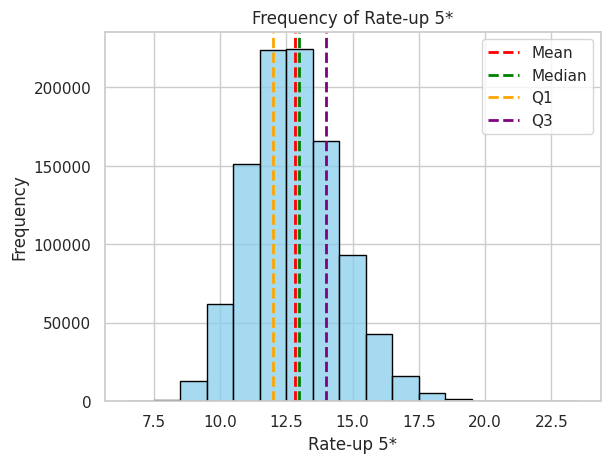

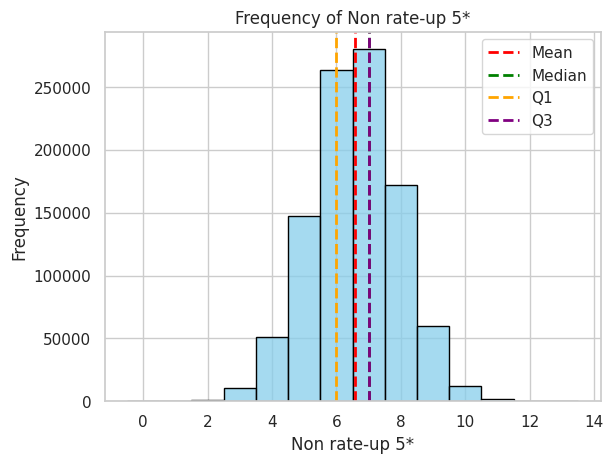

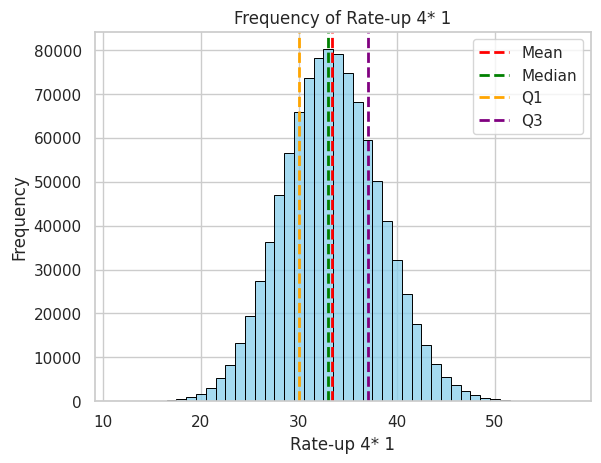

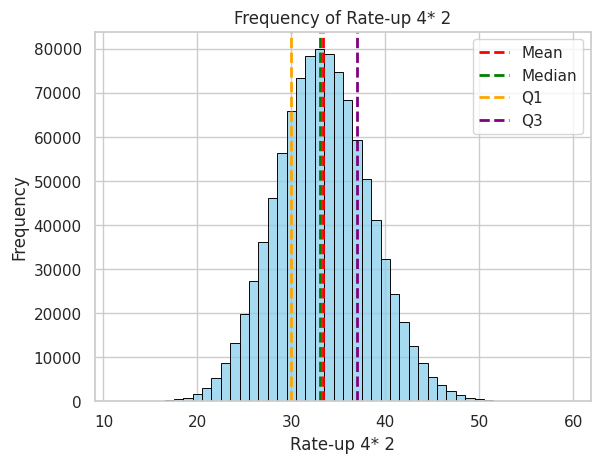

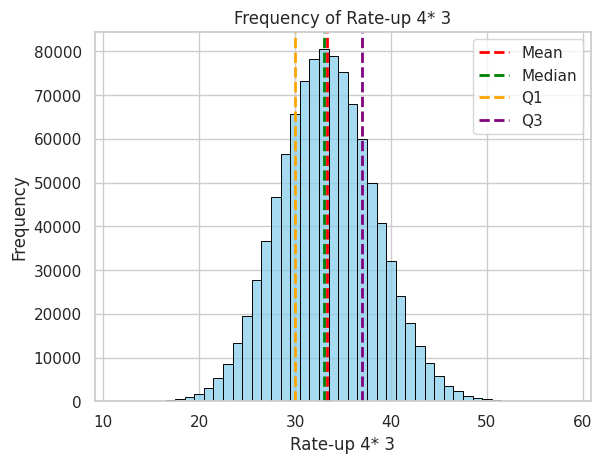

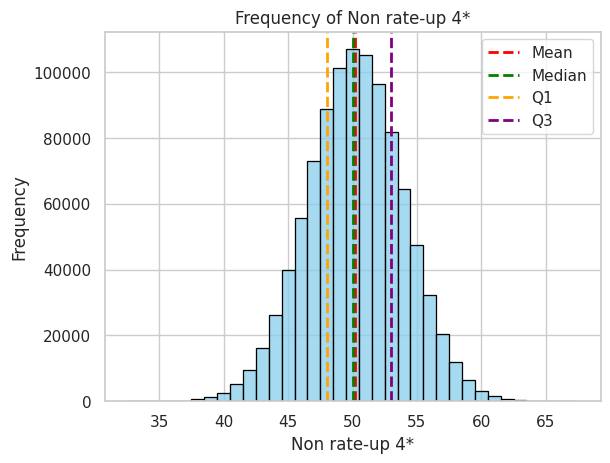

In [ ]:
# Membuat plot distribusi menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot distribusi
for column in df_sample.columns:
    plt.figure()
    sns.histplot(df_sample[column], kde=False, bins=np.arange(df_sample[column].min()-1, df_sample[column].max()+1)+0.5, color='skyblue', edgecolor='black')

    # Menambahkan garis vertikal untuk statistik
    plt.axvline(summary_stats.loc['mean', column], color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(summary_stats.loc['50%', column], color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.axvline(summary_stats.loc['25%', column], color='orange', linestyle='dashed', linewidth=2, label='Q1')
    plt.axvline(summary_stats.loc['75%', column], color='purple', linestyle='dashed', linewidth=2, label='Q3')

    # Menambahkan label dan judul
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Frequency of {column}')

    # Menampilkan legenda
    plt.legend()

# Menampilkan plot
plt.show()


<Figure size 1200x800 with 0 Axes>

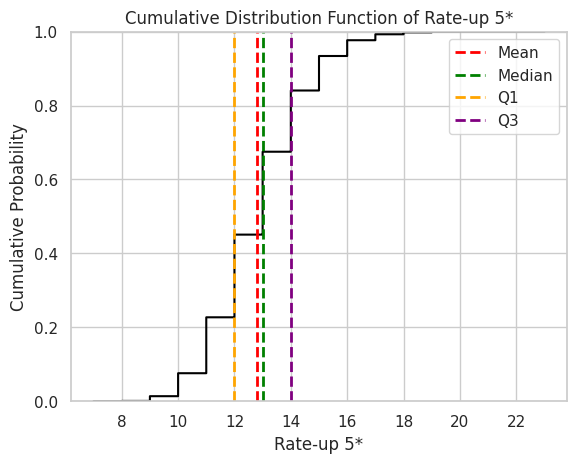

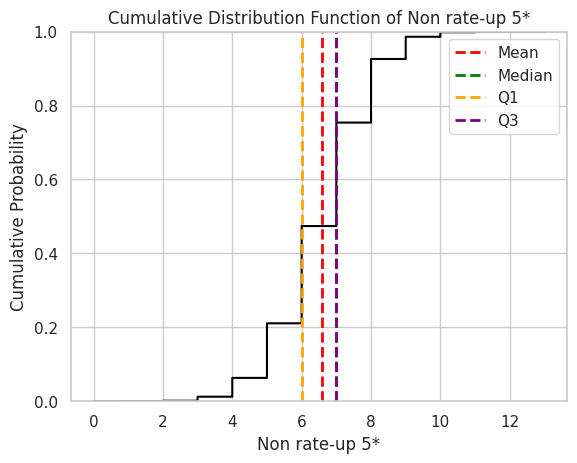

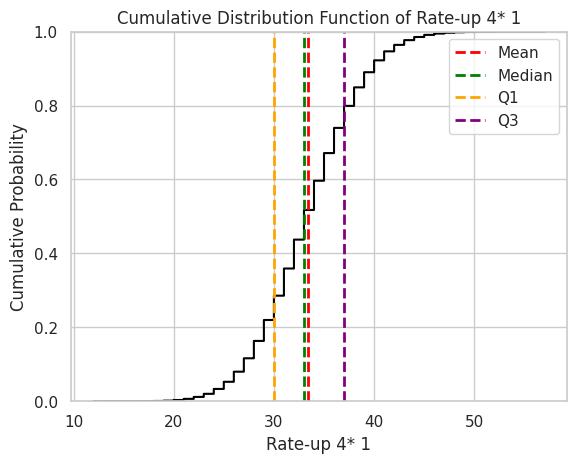

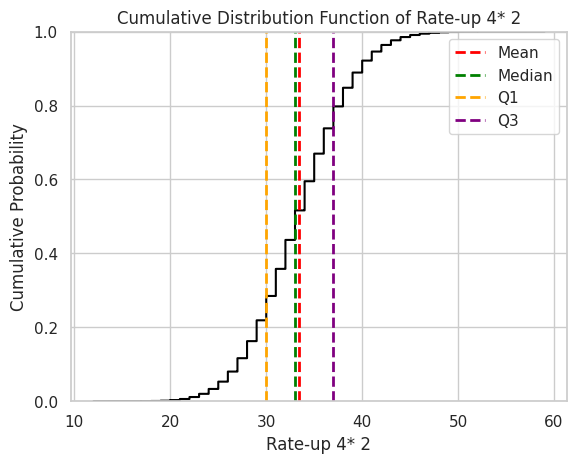

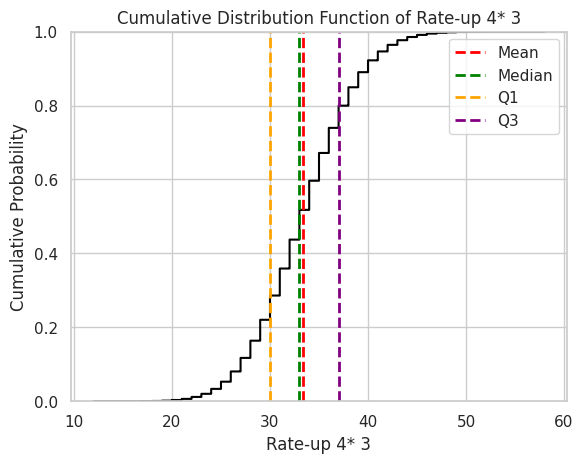

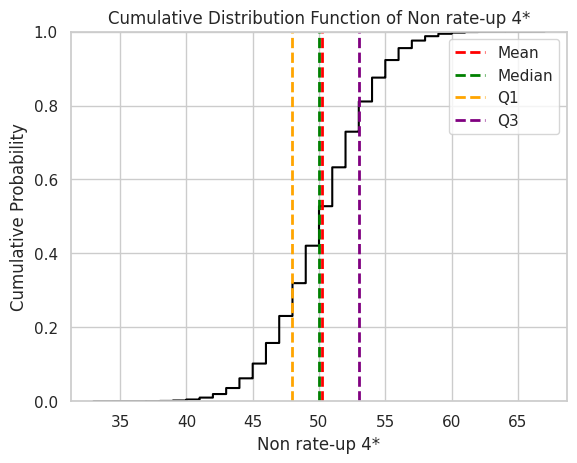

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
for column in df_sample.columns:
    plt.figure()
    sns.ecdfplot(data=df_sample[column], color='black')

    # Menambahkan garis vertikal untuk statistik
    plt.axvline(summary_stats.loc['mean', column], color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(summary_stats.loc['50%', column], color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.axvline(summary_stats.loc['25%', column], color='orange', linestyle='dashed', linewidth=2, label='Q1')
    plt.axvline(summary_stats.loc['75%', column], color='purple', linestyle='dashed', linewidth=2, label='Q3')

    # Menambahkan label dan judul
    plt.xlabel(column)
    plt.ylabel('Cumulative Probability')
    plt.title(f'Cumulative Distribution Function of {column}')

    # Menampilkan legenda
    plt.legend()

# Menampilkan plot
plt.show()


# Gacha Simulation (Reward Counter 2)

In [ ]:
62.2973*100

6229.73

In [ ]:
sample = []

for i in range(0,10000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  droplist = []
  for j in range(0,16400):
    x = random.uniform(0,1)
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
      counter4 = counter4 + 1
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter5 = counter5 + 1
      counter4 = 0
    else:
      counter5 = counter5 + 1
      counter4 = counter4 + 1
  droplist.append(char5.count("Rate-up 5*"))
  droplist.append(char5.count("Non rate-up 5*"))
  droplist.append(char4.count("Rate-up 4* 1"))
  droplist.append(char4.count("Rate-up 4* 2"))
  droplist.append(char4.count("Rate-up 4* 3"))
  droplist.append(char4.count("Non rate-up 4*"))
  sample.append(droplist)

df_sample = pd.DataFrame(sample,columns=["Rate-up 5*","Non rate-up 5*","Rate-up 4* 1","Rate-up 4* 2","Rate-up 4* 3","Non rate-up 4*"])
df_sample.head()

,Rate-up 5*,Non rate-up 5*,Rate-up 4* 1,Rate-up 4* 2,Rate-up 4* 3,Non rate-up 4*
0,175,90,465,411,428,685
1,175,82,421,420,465,657
2,176,90,466,392,456,669
3,176,91,470,445,424,624
4,166,89,444,424,450,663


In [ ]:
summary_stats = df_sample.describe()
summary_stats

,Rate-up 5*,Non rate-up 5*,Rate-up 4* 1,Rate-up 4* 2,Rate-up 4* 3,Non rate-up 4*
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.257000,86.874400,440.661200,440.556100,440.582900,661.104600
std,6.064192,4.858126,17.855282,18.140793,18.117896,13.620669
min,150.000000,70.000000,380.000000,372.000000,371.000000,613.000000
25%,169.000000,84.000000,429.000000,428.000000,428.000000,652.000000
50%,173.000000,87.000000,440.000000,441.000000,440.000000,661.000000
75%,177.000000,90.000000,453.000000,453.000000,453.000000,670.000000
max,197.000000,108.000000,515.000000,506.000000,510.000000,710.000000


<Figure size 1200x800 with 0 Axes>

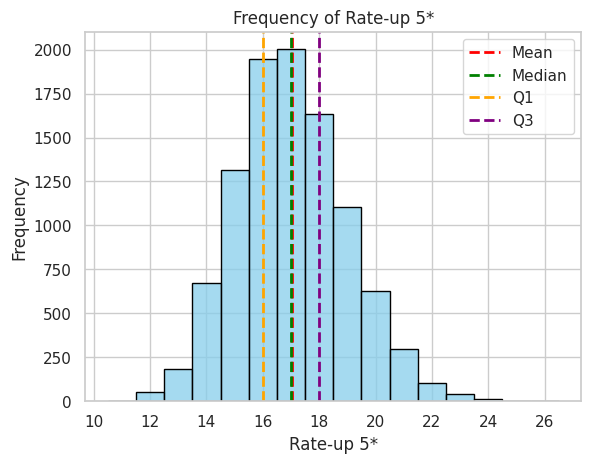

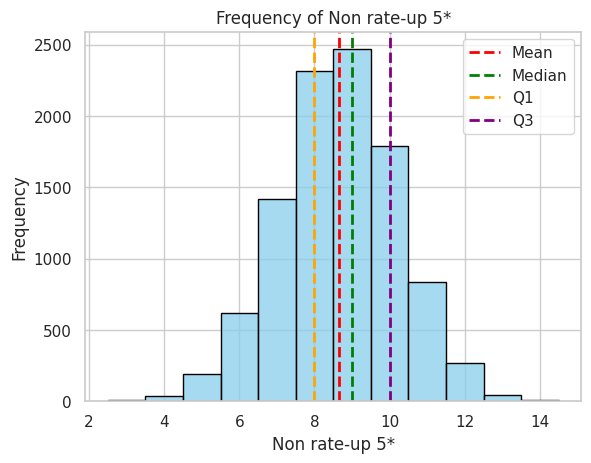

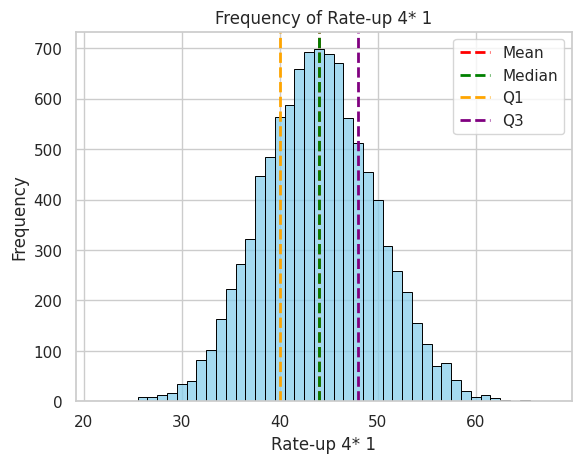

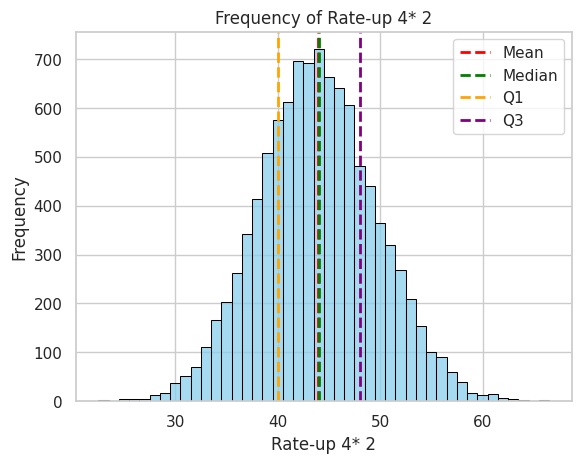

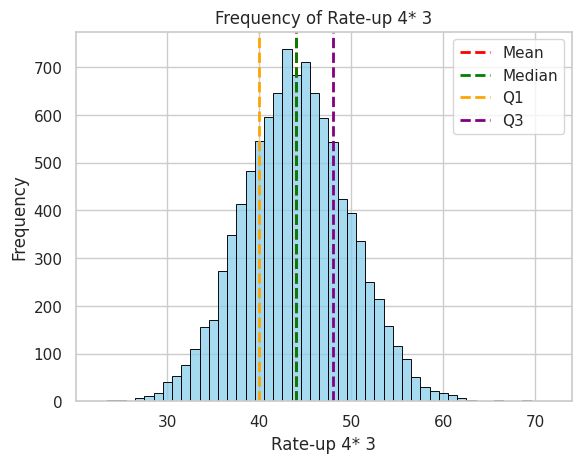

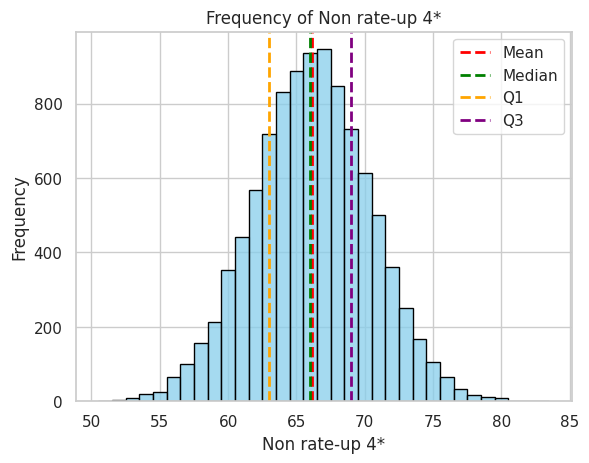

In [ ]:
# Membuat plot distribusi menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot distribusi
for column in df_sample.columns:
    plt.figure()
    sns.histplot(df_sample[column], kde=False, bins=np.arange(df_sample[column].min()-1, df_sample[column].max()+1)+0.5, color='skyblue', edgecolor='black')

    # Menambahkan garis vertikal untuk statistik
    plt.axvline(summary_stats.loc['mean', column], color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(summary_stats.loc['50%', column], color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.axvline(summary_stats.loc['25%', column], color='orange', linestyle='dashed', linewidth=2, label='Q1')
    plt.axvline(summary_stats.loc['75%', column], color='purple', linestyle='dashed', linewidth=2, label='Q3')

    # Menambahkan label dan judul
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Frequency of {column}')

    # Menampilkan legenda
    plt.legend()

# Menampilkan plot
plt.show()


<Figure size 1200x800 with 0 Axes>

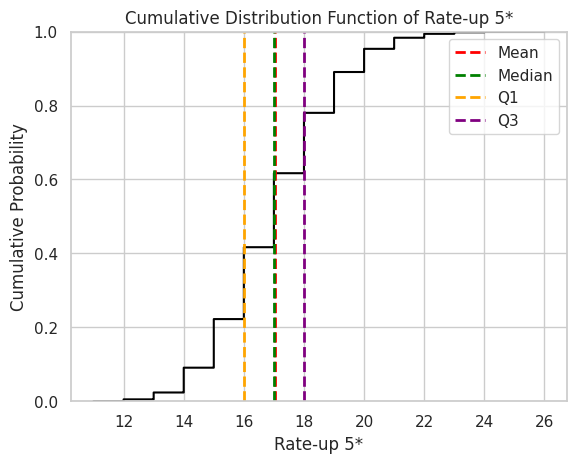

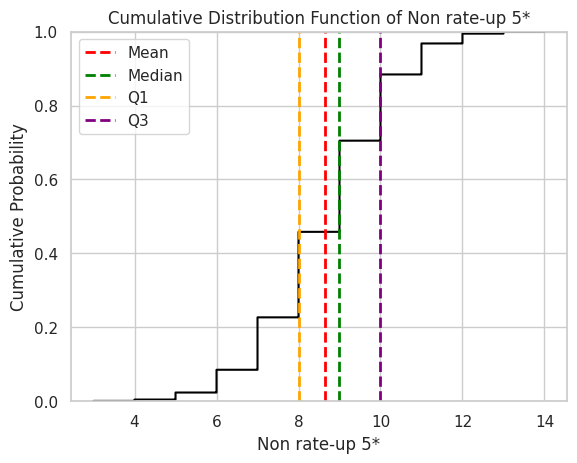

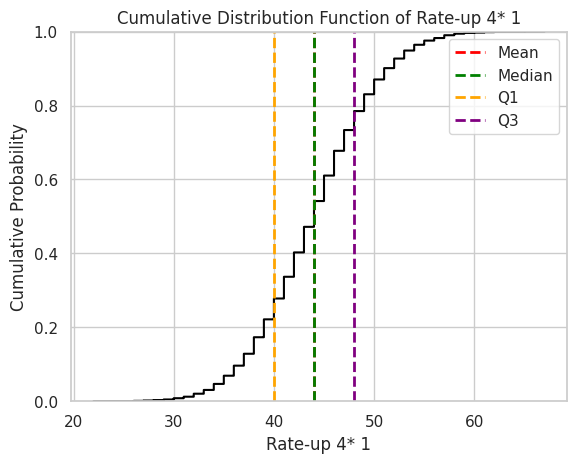

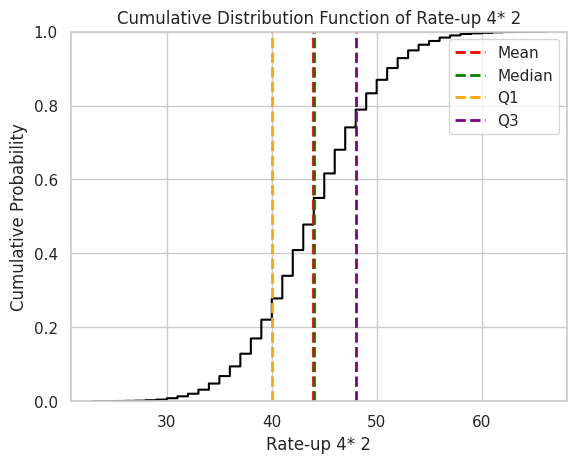

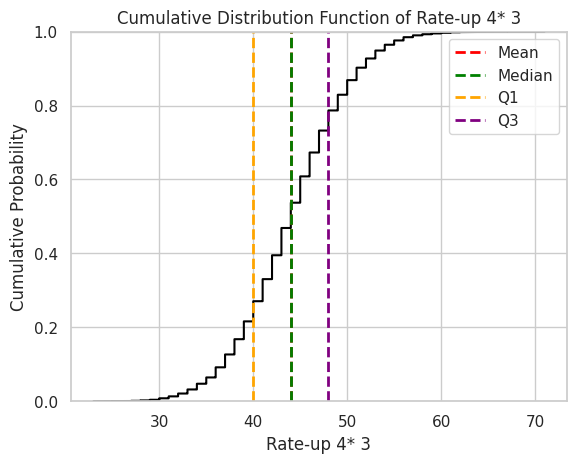

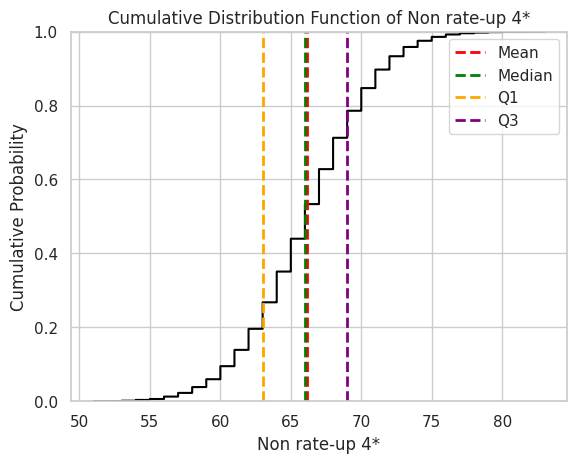

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
for column in df_sample.columns:
    plt.figure()
    sns.ecdfplot(data=df_sample[column], color='black')

    # Menambahkan garis vertikal untuk statistik
    plt.axvline(summary_stats.loc['mean', column], color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(summary_stats.loc['50%', column], color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.axvline(summary_stats.loc['25%', column], color='orange', linestyle='dashed', linewidth=2, label='Q1')
    plt.axvline(summary_stats.loc['75%', column], color='purple', linestyle='dashed', linewidth=2, label='Q3')

    # Menambahkan label dan judul
    plt.xlabel(column)
    plt.ylabel('Cumulative Probability')
    plt.title(f'Cumulative Distribution Function of {column}')

    # Menampilkan legenda
    plt.legend()

# Menampilkan plot
plt.show()


#Gacha Simulation (Any 5* Pull Counter)

In [ ]:
sample1 = []

for i in range(0,1000000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while len(char5)<1:
    x = random.uniform(0,1)
    counter5 = counter5 + 1
    counter4 = counter4 + 1
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<=prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
  sample1.append(pullcount)

In [ ]:
df_sample1 = pd.DataFrame(sample1,columns=["Number of pulls"])
df_sample1.head()
summary_stats1 = df_sample1.describe()

In [ ]:
summary_stats1

,Number of pulls
count,1000000.000000
mean,62.288432
std,24.296001
min,1.000000
25%,48.000000
50%,76.000000
75%,78.000000
max,89.000000


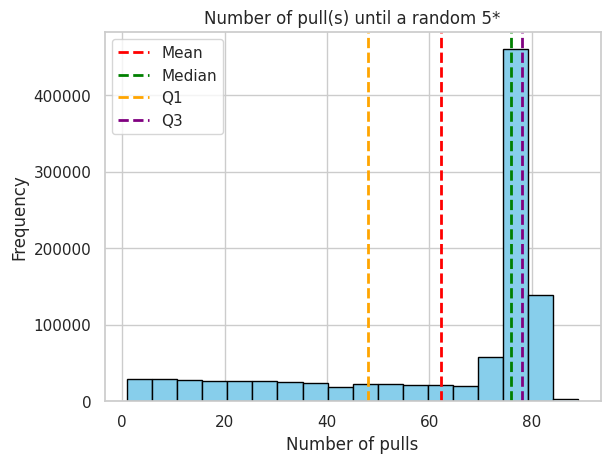

In [ ]:
plt.hist(sample1, bins=18, color='skyblue', edgecolor='black')
plt.xticks(range(0,90,20))

plt.axvline(summary_stats1.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats1.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats1.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats1.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

plt.xlabel('Number of pulls')
plt.ylabel('Frequency')
plt.title('Number of pull(s) until a random 5*')

plt.legend()

<Figure size 1200x800 with 0 Axes>

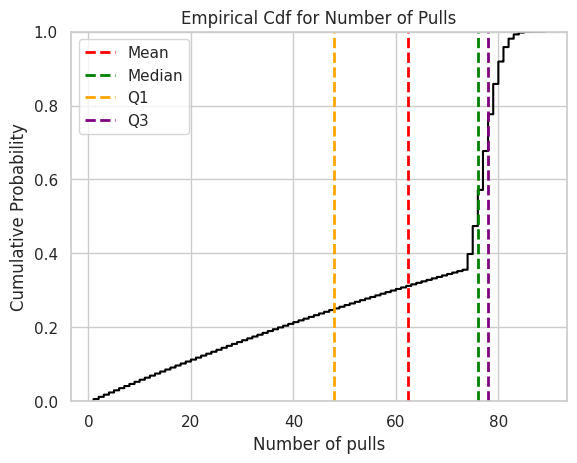

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
plt.figure()
sns.ecdfplot(data=df_sample1['Number of pulls'], color='black')

# Menambahkan garis vertikal untuk statistik
plt.axvline(summary_stats1.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats1.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats1.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats1.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

# Menambahkan label dan judul
plt.xlabel('Number of pulls')
plt.ylabel('Cumulative Probability')
plt.title(f'Empirical Cdf for Number of Pulls')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

# Gacha Simulation (Rate-up 5* Pull Counter)

In [ ]:
sample1 = []

for i in range(0,1000000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while char5.count("Rate-up 5*")!=1:
    x = random.uniform(0,1)
    counter5 = counter5 + 1
    counter4 = counter4 + 1
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter4 = 0

  sample1.append(pullcount)

In [ ]:
df_sample1 = pd.DataFrame(sample1,columns=["Number of pulls"])
df_sample1.head()

,Number of pulls
0,78
1,125
2,34
3,125
4,78


In [ ]:
summary_stats1 = df_sample1.describe()

In [ ]:
summary_stats1

,Number of pulls
count,1000000.000000
mean,93.445968
std,43.141656
min,1.000000
25%,75.000000
50%,80.000000
75%,136.000000
max,172.000000


In [ ]:
df_sample1["Number of pulls"]

,Number of pulls
0,78
1,125
2,34
3,125
4,78
...,...
999995,155
999996,79
999997,152
999998,110


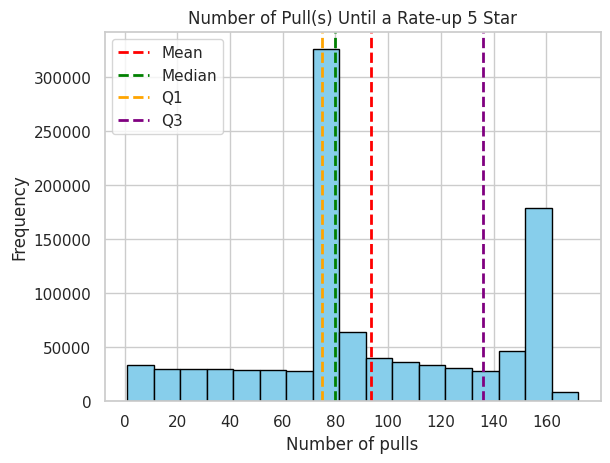

In [ ]:
plt.hist(sample1, bins=17, color='skyblue', edgecolor='black')
plt.xticks(range(0,180,20))

plt.axvline(summary_stats1.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats1.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats1.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats1.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

plt.xlabel('Number of pulls')
plt.ylabel('Frequency')
plt.title('Number of Pull(s) Until a Rate-up 5 Star')

plt.legend()

<Figure size 1200x800 with 0 Axes>

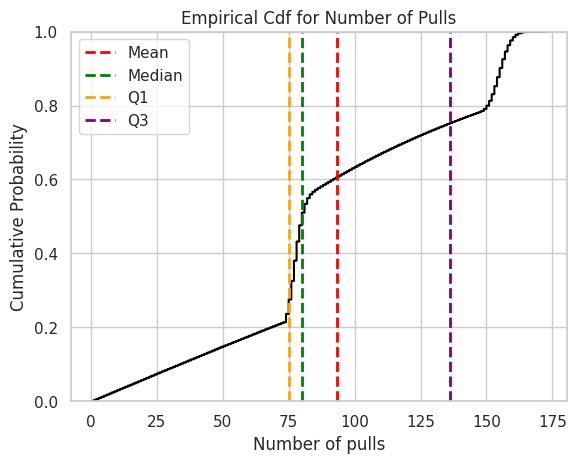

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
plt.figure()
sns.ecdfplot(data=df_sample1['Number of pulls'], color='black')

# Menambahkan garis vertikal untuk statistik
plt.axvline(summary_stats1.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats1.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats1.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats1.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

# Menambahkan label dan judul
plt.xlabel('Number of pulls')
plt.ylabel('Cumulative Probability')
plt.title(f'Empirical Cdf for Number of Pulls')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

# Gacha Simulation (Specific Rate up C6 4* Pull Counter)

In [ ]:
sample2 = []

for i in range(0,1000000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while char4.count("Rate-up 4* 1")!=7:
    x = random.uniform(0,1)
    counter5 = counter5 + 1
    counter4 = counter4 + 1
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter4 = 0

  sample2.append(pullcount)

In [ ]:
df_sample2 = pd.DataFrame(sample2,columns=["Number of pulls"])
df_sample2.head()

,Number of pulls
0,216
1,368
2,246
3,334
4,264


In [ ]:
summary_stats2 = df_sample2.describe()

In [ ]:
summary_stats2

,Number of pulls
count,1000000.000000
mean,241.156449
std,78.221255
min,37.000000
25%,185.000000
50%,231.000000
75%,287.000000
max,874.000000


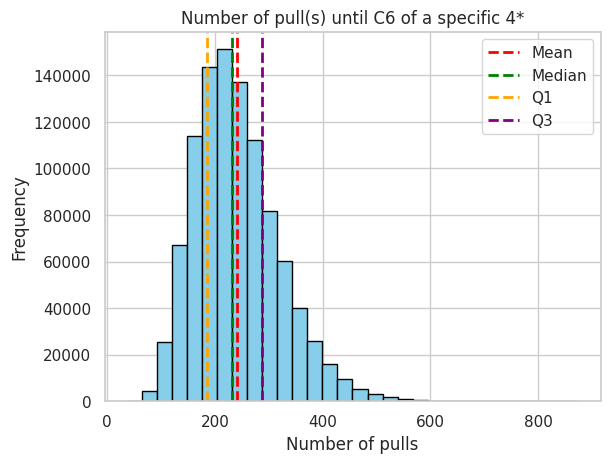

In [ ]:
plt.hist(sample2,  bins=30, color='skyblue', edgecolor='black')

plt.axvline(summary_stats2.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats2.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats2.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats2.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

plt.xlabel('Number of pulls')
plt.ylabel('Frequency')
plt.title('Number of pull(s) until C6 of a specific 4*')

plt.legend()

<Figure size 1200x800 with 0 Axes>

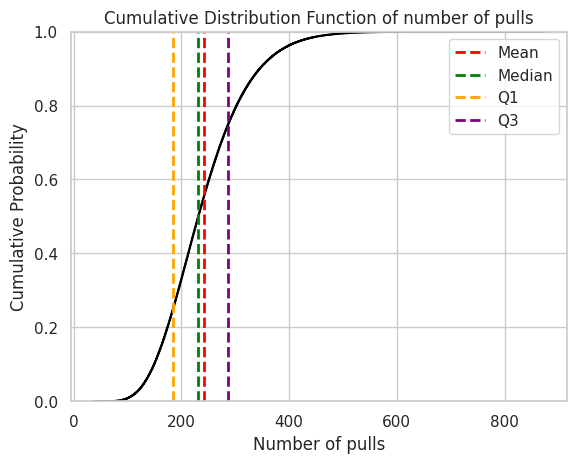

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
plt.figure()
sns.ecdfplot(data=df_sample2['Number of pulls'], color='black')

# Menambahkan garis vertikal untuk statistik
plt.axvline(summary_stats2.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats2.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats2.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats2.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

# Menambahkan label dan judul
plt.xlabel('Number of pulls')
plt.ylabel('Cumulative Probability')
plt.title(f'Cumulative Distribution Function of number of pulls')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

#Gacha Simulation (Specific Rate-up C6 5* Pull Counter)

In [ ]:
sample3 = []

for i in range(0,1000000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while char5.count("Rate-up 5*")<7:
    x = random.uniform(0,1)
    counter5 = counter5 + 1
    counter4 = counter4 + 1
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter4 = 0

  sample3.append(pullcount)

In [ ]:
df_sample3 = pd.DataFrame(sample3,columns=["Number of pulls"])
df_sample3.head()

,Number of pulls
0,897
1,694
2,642
3,469
4,740


In [ ]:
summary_stats3 = df_sample3.describe()

In [ ]:
summary_stats3

,Number of pulls
count,1000000.000000
mean,653.990821
std,114.002650
min,144.000000
25%,576.000000
50%,654.000000
75%,732.000000
max,1100.000000


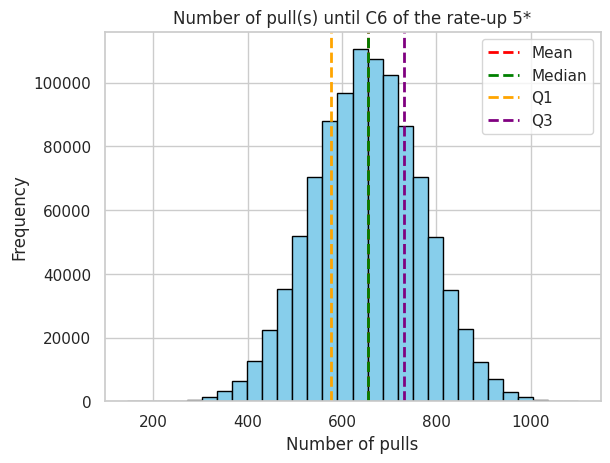

In [ ]:
plt.hist(sample3,  bins=30, color='skyblue', edgecolor='black')

plt.axvline(summary_stats3.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats3.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats3.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats3.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

plt.xlabel('Number of pulls')
plt.ylabel('Frequency')
plt.title('Number of pull(s) until C6 of the rate-up 5*')

plt.legend()

<Figure size 1200x800 with 0 Axes>

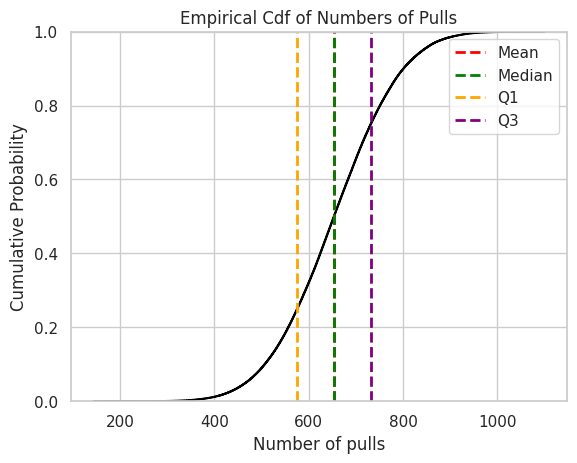

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
plt.figure()
sns.ecdfplot(data=df_sample3['Number of pulls'], color='black')

# Menambahkan garis vertikal untuk statistik
plt.axvline(summary_stats3.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats3.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats3.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats3.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

# Menambahkan label dan judul
plt.xlabel('Number of pulls')
plt.ylabel('Cumulative Probability')
plt.title(f'Empirical Cdf of Numbers of Pulls')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

#Gacha Simulation (Specific Rate-up C6 5* Pull Counter) 2

In [ ]:
sample3 = []

for i in range(0,1000000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while char5.count("Rate-up 5*")<7:
    x = random.uniform(0,1)
    counter5 = counter5 + 1
    counter4 = counter4 + 1
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter4 = 0

  sample3.append(pullcount)

In [ ]:
df_sample3 = pd.DataFrame(sample3,columns=["Number of pulls"])
df_sample3.head()

,Number of pulls
0,790
1,650
2,644
3,602
4,678


In [ ]:
summary_stats3 = df_sample3.describe()

In [ ]:
summary_stats3

,Number of pulls
count,1000000.000000
mean,654.331583
std,114.045546
min,147.000000
25%,576.000000
50%,654.000000
75%,732.000000
max,1105.000000


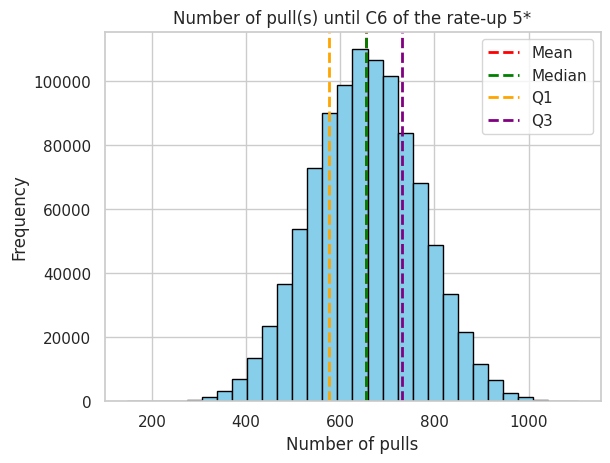

In [ ]:
plt.hist(sample3,  bins=30, color='skyblue', edgecolor='black')

plt.axvline(summary_stats3.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats3.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats3.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats3.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

plt.xlabel('Number of pulls')
plt.ylabel('Frequency')
plt.title('Number of pull(s) until C6 of the rate-up 5*')

plt.legend()

<Figure size 1200x800 with 0 Axes>

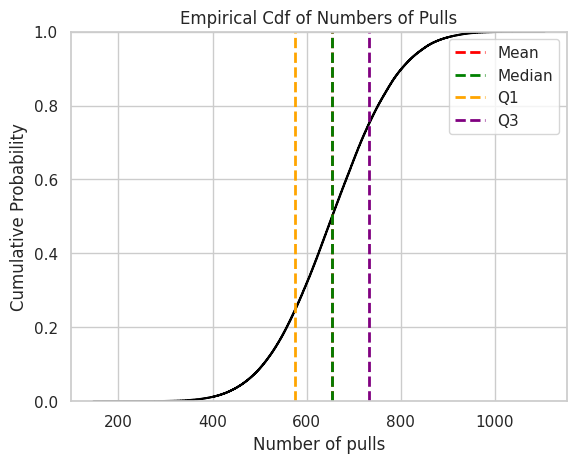

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
plt.figure()
sns.ecdfplot(data=df_sample3['Number of pulls'], color='black')

# Menambahkan garis vertikal untuk statistik
plt.axvline(summary_stats3.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats3.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats3.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats3.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

# Menambahkan label dan judul
plt.xlabel('Number of pulls')
plt.ylabel('Cumulative Probability')
plt.title(f'Empirical Cdf of Numbers of Pulls')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

#Gacha Simulation (Test)

In [ ]:
sample4 = []

for i in range(0,10000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while char5.count("Rate-up 5*")<3:
    x = random.uniform(0,1)
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
      counter4 = counter4 + 1
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter5 = counter5 + 1
      counter4 = 0
    else:
      counter5 = counter5 + 1
      counter4 = counter4 + 1
  sample4.append(pullcount)

In [ ]:
df_sample4 = pd.DataFrame(sample3,columns=["Number of pulls"])
df_sample4.head()

,Number of pulls
0,371
1,261
2,318
3,322
4,306


In [ ]:
summary_stats4 = df_sample4.describe()

In [ ]:
summary_stats4

,Number of pulls
count,10000.000000
mean,283.214100
std,75.182512
min,33.000000
25%,234.000000
50%,284.000000
75%,332.000000
max,491.000000


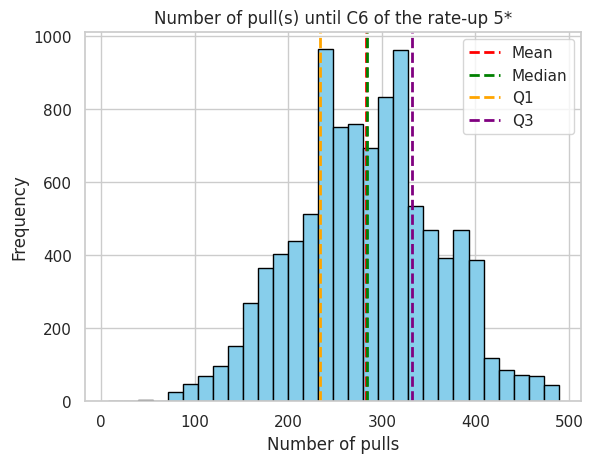

In [ ]:
plt.hist(sample4,  bins=30, color='skyblue', edgecolor='black')

plt.axvline(summary_stats4.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats4.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats4.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats4.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

plt.xlabel('Number of pulls')
plt.ylabel('Frequency')
plt.title('Number of pull(s) until C6 of the rate-up 5*')

plt.legend()

<Figure size 1200x800 with 0 Axes>

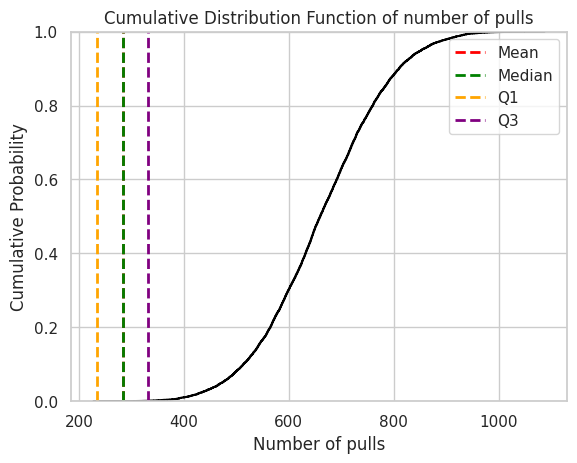

In [ ]:
# Membuat plot CDF menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Looping untuk setiap kolom dan membuat plot CDF
plt.figure()
sns.ecdfplot(data=df_sample4['Number of pulls'], color='black')

# Menambahkan garis vertikal untuk statistik
plt.axvline(summary_stats4.loc['mean', 'Number of pulls'], color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(summary_stats4.loc['50%', 'Number of pulls'], color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(summary_stats4.loc['25%', 'Number of pulls'], color='orange', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(summary_stats4.loc['75%', 'Number of pulls'], color='purple', linestyle='dashed', linewidth=2, label='Q3')

# Menambahkan label dan judul
plt.xlabel('Number of pulls')
plt.ylabel('Cumulative Probability')
plt.title(f'Cumulative Distribution Function of number of pulls')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

In [ ]:
1000/93.7985

10.661151297728642

#Expectation Calculation

In [ ]:
prob = [0]
for i in range(1,91):
  prob.append(min(0.006 + 0.06*max(0,i-pity5),1))

In [ ]:
len(prob)

91

In [ ]:
for i in range(10):
  print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
#any 5*
exp0 = 0

for i in range (1,91):
  fail = 1
  for j in range(i):
    fail = fail*(1-prob[j])
  pr1 = fail*prob[i]
  exp0 += i*min(1,pr1)
  pr0 = pr1
print(exp0)
print(1.5*exp0)

62.297332039630945
93.44599805944642


In [ ]:
exp0 = 0
for i in range (1,91):
  fail = 1
  for j in range(i):
    fail = fail*(1-prob[j])
  pr1 = fail*prob[i]
  exp0 += 1*pr1
  pr0 = pr1
print(exp0)

0.9999999999999996


#**Archive**

In [ ]:
sample1 = []

for i in range(0,1000):
  counter4 = 0
  counter5 = 0
  guarantee4 = 0
  guarantee5 = 0
  char5 = []
  char4 = []
  pullcount = 0
  while len(char5)<1:
    x = random.uniform(0,1)
    prob4 = rate4 + max(0,counter4-pity4)*rate4*10
    prob5 = rate5 + max(0,counter5-pity5)*rate5*10
    pullcount = pullcount + 1
    if x<prob5:
      char5,guarantee5 = drop5(char5,guarantee5)
      counter5 = 0
      counter4 = counter4 + 1
    elif x<prob5+prob4:
      char4,guarantee4 = drop4(char4,guarantee4)
      counter5 = counter5 + 1
      counter4 = 0
    else:
      counter5 = counter5 + 1
      counter4 = counter4 + 1
  sample1.append(pullcount)